### Imports and Configuration

This cell sets up the environment by importing necessary libraries and defining key parameters for performing object detection using a Faster R-CNN ONNX model.

*   **Imports**: Essential libraries for ONNX inference (`onnxruntime`), array manipulation (`numpy`), image handling (`PIL`, `cv2`), and plotting (`matplotlib.pyplot`) are loaded.
*   **Model Type**: The task is based on a **Faster R-CNN with a ResNet-101** backbone, a high-accuracy, two-stage object detection model.
*   **Configuration**: Defines file paths, the model's target input size (`IMAGE_SIZE = (256, 256)`), and the thresholds for filtering (`CONFIDENCE_THRESHOLD = 0.55`) and cleanup (`NMS_IOU_THRESHOLD = 0.4`).

In [1]:
import numpy as np
from PIL import Image
import onnxruntime as ort
import matplotlib.pyplot as plt
import cv2

# --- CONFIG ---
ONNX_MODEL_PATH = "marine_debris_detector.onnx"
IMAGE_PATH = "./images/debris/20170227_203601_0c46_16903-29838-16.jpg"
CONFIDENCE_THRESHOLD = 0.55
IMAGE_SIZE = (256, 256)  # Resize to match ONNX model input
NMS_IOU_THRESHOLD = 0.4  # IoU threshold for NMS

### Helper Functions (Pre-process and Post-process)

This cell defines two essential functions that manage the model's data flow, specifically tailored to the observed I/O format:

1.  **`preprocess_image`**:
    *   Loads the image and records the original size.
    *   Resizes to $\mathbf{256 \times 256}$.
    *   The core transformation converts the image to a NumPy array, **transposes it to the $\mathbf{[3, 256, 256]}$ ($\mathbf{C, H, W}$) tensor format**, and normalizes the pixel values to $\mathbf{0.0 - 1.0}$. This structure (lack of batch dimension) matches the model's reported input shape.

2.  **`postprocess_output`**: This function is designed for the $\mathbf{[N, \dots]}$ output format ($\mathbf{40}$ proposals) of the Faster R-CNN model.
    *   **Filtering**: Filters the proposals by the $\mathbf{0.55}$ confidence score.
    *   **NMS Preparation**: Converts the $\mathbf{[\text{xmin}, \text{ymin}, \text{xmax}, \text{ymax}]}$ box format to the $\mathbf{[x, y, w, h]}$ format required by `cv2.dnn.NMSBoxes`.
    *   **NMS Execution**: Applies Non-Maximum Suppression with the $\mathbf{0.4}$ IoU threshold.
    *   **Rescaling**: Scales the final, selected box coordinates from the $\mathbf{256 \times 256}$ model input space back to the original image dimensions.

In [2]:
# --- HELPER FUNCTIONS ---


def preprocess_image(img_path, target_size):
    """Loads, resizes, and normalizes an image for ONNX model input."""
    original_image = Image.open(img_path).convert("RGB")
    original_size = original_image.size

    # Resize to model's expected input size
    image = original_image.resize(target_size)

    # Convert to numpy array, transpose to [C, H, W], normalize to 0.0-1.0
    input_tensor = np.array(image).transpose(2, 0, 1).astype(np.float32) / 255.0

    return input_tensor, original_image, original_size


def postprocess_output(
    pred_boxes, pred_scores, original_size, model_size, conf_thresh, nms_thresh
):
    """Filters by confidence, applies NMS, and rescales boxes to original image dimensions."""

    # Filter by Confidence
    boxes = np.array(pred_boxes[0])  # Assuming output is [1, N, 4] -> take [N, 4]
    scores = np.array(pred_scores[0])  # Assuming output is [1, N] -> take [N]

    mask = scores >= conf_thresh
    boxes = boxes[mask]
    scores = scores[mask]

    if len(boxes) == 0:
        return np.array([]), np.array([])

    # Rescale boxes from model_size to original_size for NMS to work on correct relative coordinates
    # The output from the model is already scaled to the input size (256, 256),
    # but for visualization, we need to rescale later. NMS is usually done on
    # normalized (0-1) or absolute (input size) coords. We'll do NMS on the input size coords.

    # Convert from [xmin, ymin, xmax, ymax] to [x, y, w, h] for cv2.dnn.NMSBoxes
    boxes_xywh = boxes.copy()
    boxes_xywh[:, 2] = boxes[:, 2] - boxes[:, 0]  # width
    boxes_xywh[:, 3] = boxes[:, 3] - boxes[:, 1]  # height

    # Apply NMS
    indices = cv2.dnn.NMSBoxes(
        bboxes=boxes_xywh.tolist(),
        scores=scores.tolist(),
        score_threshold=conf_thresh,
        nms_threshold=nms_thresh,
    )

    if len(indices) == 0:
        return np.array([]), np.array([])

    indices = indices.flatten()
    final_boxes = boxes[indices]
    final_scores = scores[indices]

    # Rescale final boxes to original image dimensions
    w_orig, h_orig = original_size
    w_model, h_model = model_size

    # Calculate scale factors
    x_scale = w_orig / w_model
    y_scale = h_orig / h_model

    final_boxes[:, 0] *= x_scale  # xmin
    final_boxes[:, 2] *= x_scale  # xmax
    final_boxes[:, 1] *= y_scale  # ymin
    final_boxes[:, 3] *= y_scale  # ymax

    return final_boxes.astype(int), final_scores


### Model Loading and Inference Execution

This cell executes the core inference pipeline using the observed $\mathbf{C, H, W}$ input format and printing the diagnostics.

1.  **Model Loading and I/O Inspection**:
    *   **Input Key/Shape**: The model expects input **`input_image`** with a static shape of $\mathbf{[3, 256, 256]}$, confirming the model is designed to accept a single $\mathbf{C, H, W}$ image tensor without an explicit batch dimension.
    *   **Output Keys/Shapes**: The model outputs three tensors (`boxes`, `labels`, `scores`), all structured as $\mathbf{[\text{num\_detections}, \dots]}$.

2.  **Pre-processing**:
    *   The `preprocess_image` function is called, returning the $\mathbf{(3, 256, 256)}$ tensor.
    *   The **Actual Input Shape** confirms the tensor matches the model's required format.

3.  **Inference**:
    *   The `ort_session.run()` command executes the model, passing the single $\mathbf{(3, 256, 256)}$ tensor.
    *   **Actual Output Shapes**: The raw output confirms the actual shapes are $\mathbf{(40, 4)}$, $\mathbf{(40,)}$, and $\mathbf{(40,)}$, representing $\mathbf{40}$ initial detections ready for the post-processing and NMS step.

In [3]:
# --- EXECUTION ---

# --- 3. Load ONNX model and get I/O info ---
ort_session = ort.InferenceSession(ONNX_MODEL_PATH)
input_info = ort_session.get_inputs()[0]
output_info_list = ort_session.get_outputs()  # Get all outputs
output_names = [o.name for o in output_info_list]
output_shapes = [o.shape for o in output_info_list]

input_name = input_info.name
input_shape = input_info.shape

print(f"Model Input Name: {input_name}")
print(f"Static Input Shape: {input_shape}")
print("-" * 30)
for name, shape in zip(output_names, output_shapes):
    print(f"Model Output Name: {name}")
    print(f"Static Output Shape: {shape}")
print("-" * 30)

# --- 4. Preprocess image ---
input_tensor, original_image, original_size = preprocess_image(IMAGE_PATH, IMAGE_SIZE)
print(f"Preprocessed Input Tensor Shape (Actual): {input_tensor.shape}")
print(f"Original Image Size (W, H): {original_size}")
print("-" * 30)

# --- 5. Run inference ---
# The model has multiple outputs (boxes, labels, scores)
outputs = ort_session.run(output_names, {input_name: input_tensor})
pred_boxes_raw, pred_labels_raw, pred_scores_raw = outputs

print("Inference Complete. Raw Output Shapes (Actual):")
print(f"  Boxes: {pred_boxes_raw.shape}")
print(f"  Labels: {pred_labels_raw.shape}")
print(f"  Scores: {pred_scores_raw.shape}")


Model Input Name: input_image
Static Input Shape: [3, 256, 256]
------------------------------
Model Output Name: boxes
Static Output Shape: ['num_detections', 4]
Model Output Name: labels
Static Output Shape: ['num_detections']
Model Output Name: scores
Static Output Shape: ['num_detections']
------------------------------
Preprocessed Input Tensor Shape (Actual): (3, 256, 256)
Original Image Size (W, H): (256, 256)
------------------------------
Inference Complete. Raw Output Shapes (Actual):
  Boxes: (40, 4)
  Labels: (40,)
  Scores: (40,)


### Post-processing and Visualization

This cell concludes the pipeline by cleaning up the detections and presenting the final output.

1.  **Post-processing**: The `postprocess_output` function is executed. It performs three critical operations:
    *   Filters predictions by `CONFIDENCE_THRESHOLD`.
    *   Applies Non-Maximum Suppression (NMS) using the $\mathbf{0.4}$ IoU threshold to remove highly overlapping boxes.
    *   **Rescales** the coordinates of the final, non-overlapping boxes from the $256 \times 256$ input size to the original image dimensions.
2.  **Visualization**:
    *   The final, cleaned bounding boxes (`final_boxes`) are drawn onto the original, unresized image using `matplotlib.pyplot`.
    *   A label with the confidence score is placed above each box. The visualization confirms the successful end-to-end execution of the Faster R-CNN ONNX model.

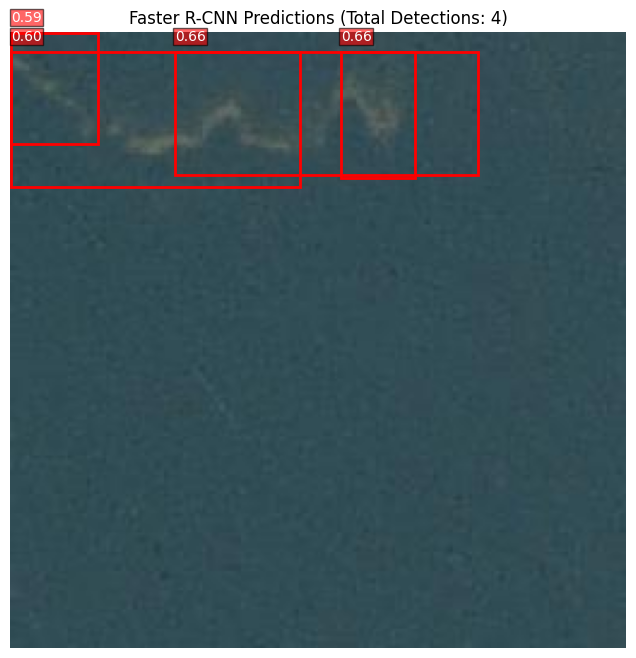

In [4]:
# --- 6. Post-processing (NMS + Rescale) ---
# The raw outputs from ort.session.run are (pred_boxes_raw, pred_labels_raw, pred_scores_raw)
# pred_boxes_raw, pred_scores_raw must be passed as a list/tuple containing the raw array
final_boxes, final_scores = postprocess_output(
    pred_boxes=[pred_boxes_raw],
    pred_scores=[pred_scores_raw],
    original_size=original_size,
    model_size=IMAGE_SIZE,
    conf_thresh=CONFIDENCE_THRESHOLD,
    nms_thresh=NMS_IOU_THRESHOLD,
)

# --- 7. Visualization ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(original_image)
ax.axis("off")
ax.set_title(f"Faster R-CNN Predictions (Total Detections: {len(final_boxes)})")

for box, score in zip(final_boxes, final_scores):
    xmin, ymin, xmax, ymax = box

    # Draw Rectangle
    rect = plt.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        fill=False,
        edgecolor="red",
        linewidth=2,
    )
    ax.add_patch(rect)

    # Draw Label (using score as the class name is not available in the provided code)
    ax.text(
        xmin,
        ymin - 5,
        f"{score:.2f}",
        color="white",
        bbox=dict(facecolor="red", alpha=0.6, pad=1),
    )

plt.show()
